# Advanced Latent Optimization Strategies

This notebook trains a small demo model on the sample polymer data (density target) and then explores `optimize_latent` strategies:
1. Data-driven initialization (seeds from descriptors)
2. Perturbation to escape local optima
3. Multi-restart for global search
4. Comparison of different starting strategies


In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import random

from pymatgen.core.composition import Composition

from pathlib import Path

from foundation_model.models.flexible_multi_task_model import FlexibleMultiTaskModel
from foundation_model.models.model_config import (
    MLPEncoderConfig,
    RegressionTaskConfig,
    AutoEncoderTaskConfig,
    OptimizerConfig,
)

from foundation_model.utils.kmd_plus import (
    KMD,
    element_features,  # Element-level descriptors of shape (94, 58).
    formula_to_composition,
)

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Libraries loaded (device={device})")


✓ Libraries loaded (device=cpu)


In [2]:
def decoded_weight_to_composition(decoded_weight, component_features, *, min_ratio=0.0):
    """
    Convert decoded weights to a list of composition dictionaries.
    Elements with ratio < min_ratio are filtered out, and their mass is
    redistributed evenly among the remaining elements.
    All ratios are normalized to 0.005 intervals.

    Args:
        decoded_weight: numpy array of shape (n_samples, n_elements) containing element ratios
        component_features: pandas DataFrame with element symbols as index
        min_ratio: minimum ratio threshold for keeping an element (default: 0.0)

    Returns:
        List of dictionaries, each mapping element symbols to their ratios
    """
    compositions = []
    element_symbols = component_features.index.tolist()

    for i in range(decoded_weight.shape[0]):
        # Get non-zero ratios
        raw_composition = {}
        for j, element in enumerate(element_symbols):
            ratio = decoded_weight[i, j]
            if ratio > 0:
                raw_composition[element] = ratio.item()

        # Filter ratios >= min_ratio
        filtered_composition = {k: v for k, v in raw_composition.items() if v >= min_ratio}

        if not filtered_composition:
            # If all ratios < min_ratio, keep the largest one
            if raw_composition:
                max_element = max(raw_composition, key=raw_composition.get)
                compositions.append({max_element: 1.0})
            else:
                compositions.append({})
            continue

        # Calculate total mass to redistribute
        total_mass = sum(raw_composition.values())
        filtered_mass = sum(filtered_composition.values())
        redistributed_mass = total_mass - filtered_mass

        # Redistribute evenly among remaining elements
        num_remaining = len(filtered_composition)
        redistribution_per_element = redistributed_mass / num_remaining

        # Apply redistribution and normalize to 0.005 intervals
        final_composition = {}
        for element, ratio in filtered_composition.items():
            new_ratio = ratio + redistribution_per_element
            # Round to nearest 0.005
            normalized_ratio = round(new_ratio / 0.005) * 0.005
            final_composition[element] = normalized_ratio

        compositions.append(final_composition)

    return compositions

In [3]:
target_path = Path('../data/qc_ac_te_mp_dos_reformat_20250615.pd.parquet')


# Load the dataset for the KmdPlus tutorial.
# Chemical formulas of all stable materials listed in Materials Project (2022/08/07), and their formation energies.
MP_stable = pd.read_parquet(target_path)
MP_stable.composition = MP_stable.composition.apply(lambda x: {k: v for k, v in x.items() if v is not None})

fliter = [Composition.from_dict(comp).valid for comp in MP_stable.composition]
MP_stable = MP_stable[fliter]
MP_stable

,formula,Material type,Space group,composition,elements,Band gap,Density,Efermi,Final energy per atom,Formation energy per atom,...,Electrical resistivity (normalized),Power factor (normalized),Seebeck coefficient (normalized),Thermal conductivity (normalized),ZT (normalized),Magnetic susceptibility (normalized),DOS energy,DOS density,DOS density (normalized),split
id,,,,,,,,,,,,,,,,,,,,,
mp-111,Ne,others,Fm-3m,{'Ne': 1.0},[Ne],11.6898,1.815607,-9.772494,-1.912824,0.000000,...,None,None,None,None,None,None,None,None,None,val
mp-23158,He,others,Im-3m,{'He': 1.0},[He],17.6377,0.384324,-13.591344,-0.313901,0.000000,...,None,None,None,None,None,None,None,None,None,train
mp-23155,Ar,others,Fm-3m,{'Ar': 1.0},[Ar],8.5132,1.720053,-5.482198,-4.858515,0.000000,...,None,None,None,None,None,None,None,None,None,train
mp-1525632,F2,others,Cmce,{'F': 4.0},[F],2.8979,2.366529,-4.635707,-3.126028,0.000000,...,None,None,None,None,None,None,None,None,None,val
mp-1095223,OF2,others,Pnma,"{'F': 8.0, 'O': 4.0}","[F, O]",2.1241,2.196288,-2.171794,-3.421278,-0.496056,...,None,None,None,None,None,None,None,None,None,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mp-1201016,Cs9Fe2Se7,others,P2_13,"{'Cs': 36.0, 'Fe': 8.0, 'Se': 28.0}","[Cs, Fe, Se]",0.5130,4.183524,1.776250,-3.858616,-1.103992,...,None,None,None,None,None,None,None,None,None,test
mp-581173,Cs10Si7O9,others,P2/c,"{'Cs': 40.0, 'O': 36.0, 'Si': 28.0}","[Cs, O, Si]",1.4150,3.676090,2.604339,-5.347066,-1.824426,...,None,None,None,None,None,None,None,None,None,train
mp-582182,Cs5In3As4,others,P2_1/c,"{'As': 32.0, 'Cs': 40.0, 'In': 24.0}","[As, Cs, In]",0.9419,4.834335,3.608423,-3.032848,-0.408023,...,None,None,None,None,None,None,None,None,None,train


In [4]:
# Convert chemical formulas to compositions.
MP_weight = MP_stable.composition.apply(formula_to_composition)
MP_weight = np.stack(MP_weight.values)
component_features = element_features

MP_weight.shape
component_features.shape

(94, 58)

In [5]:
# Generate the kernel mean descriptors (KMD) for each feature, then combine them.
kmd_1d = KMD("1d")  # Unidimensional KMD; the kernel mean is discretized at the n_grids equally spaced grids

# Generate 2 types of descriptors with the default settings (materials → descriptors).
kmd1d = kmd_1d.transform(MP_weight, component_features, 10)

# Add index to the KMD DataFrame.
kmd1d_desc = pd.DataFrame(kmd1d, index=MP_stable.index)

/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


## Train a quick model using sample polymer data

We load descriptors/targets from `samples/dynamic_task_suite_config.toml` paths, fit a small model on `density`, and reuse that model for latent optimization.


Epoch 50: loss=0.1872
Epoch 100: loss=0.1720
Epoch 150: loss=0.1047
Epoch 200: loss=0.0665
Epoch 250: loss=0.0737
Epoch 300: loss=0.0570
Epoch 350: loss=0.0787
Epoch 400: loss=0.0485
Epoch 450: loss=0.0906
Epoch 500: loss=0.0457
Training complete. Samples used: 3604, input_dim=580


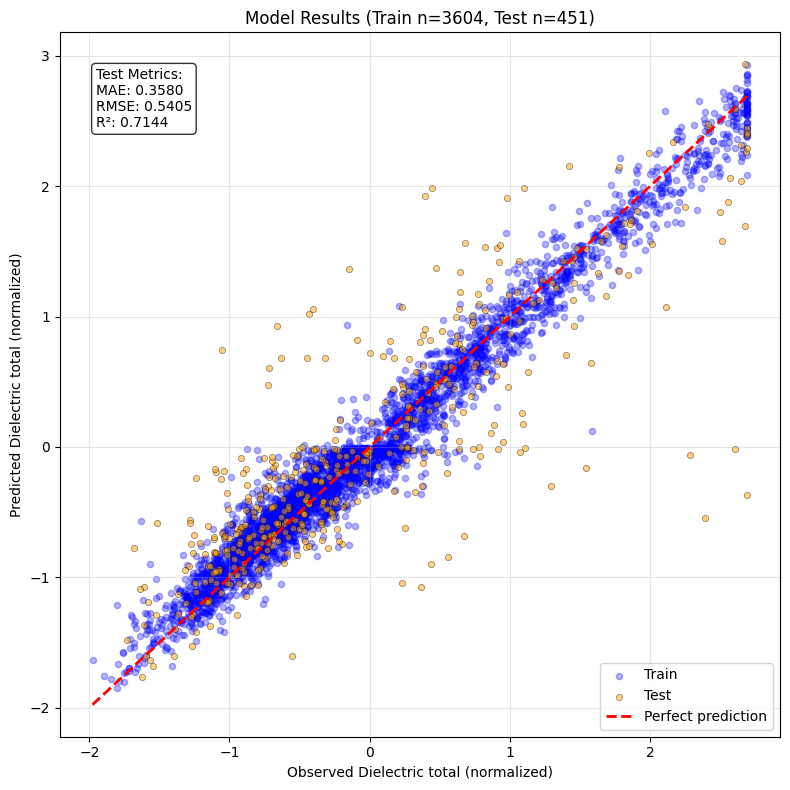


Train Set Metrics:
  MAE:  0.1369
  RMSE: 0.1808
  R²:   0.9673

Test Set Metrics:
  MAE:  0.3580
  RMSE: 0.5405
  R²:   0.7144

AutoEncoder Reconstruction Metrics (Test Set):
  MSE: 0.001055
  MAE: 0.020153


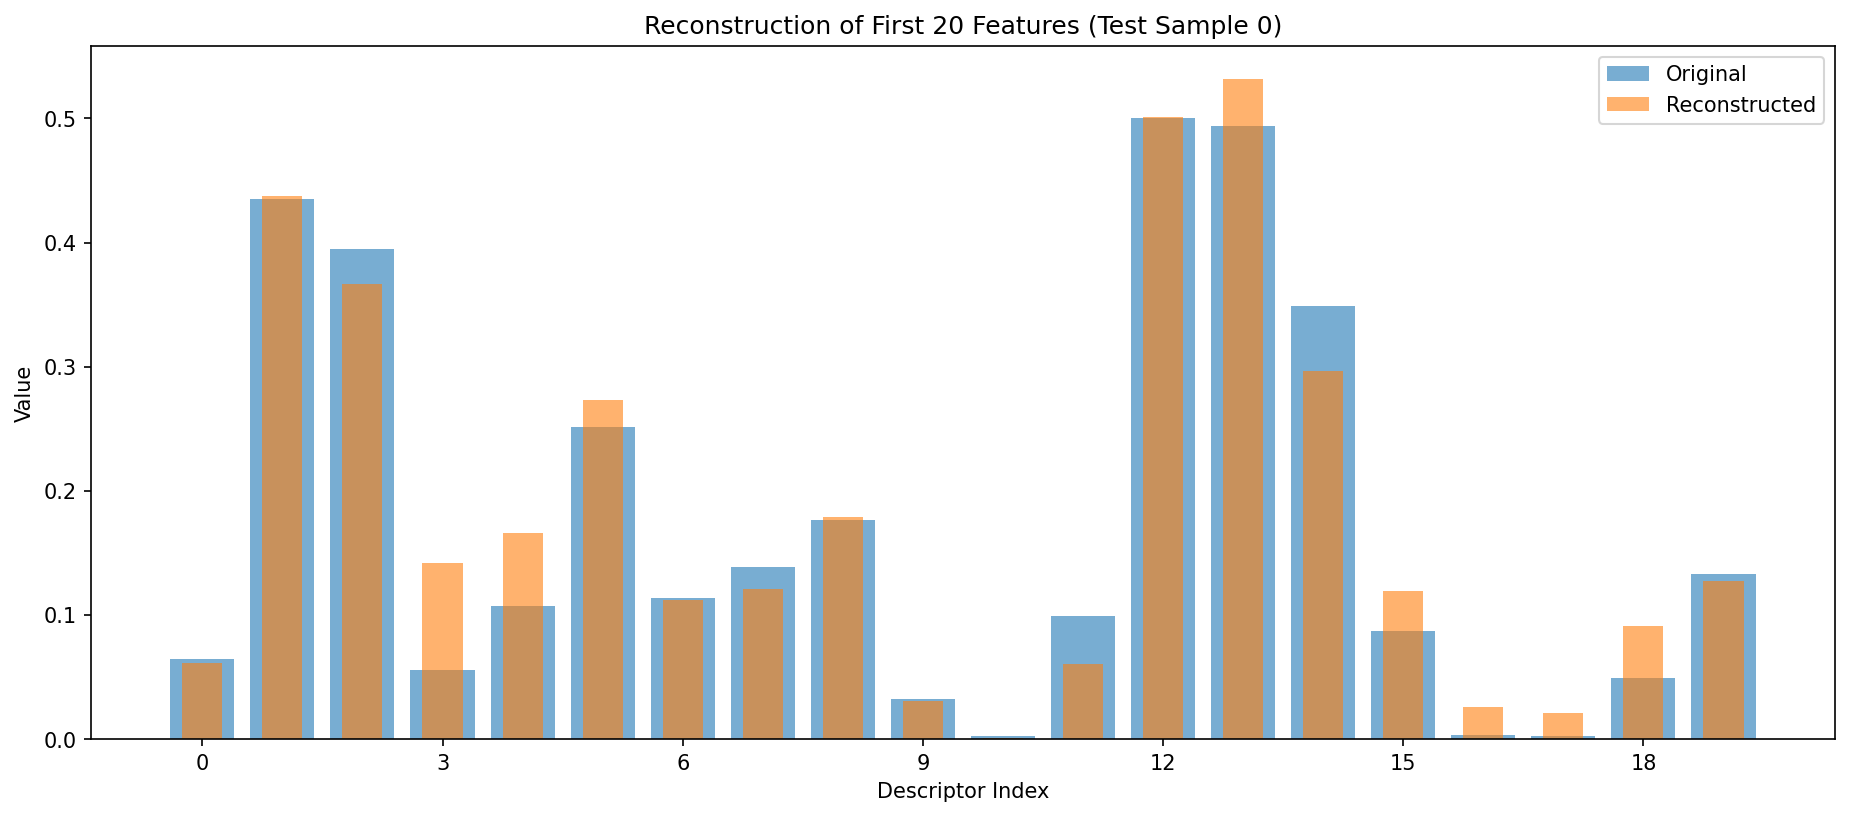


Analyzing Composition Reconstruction...


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


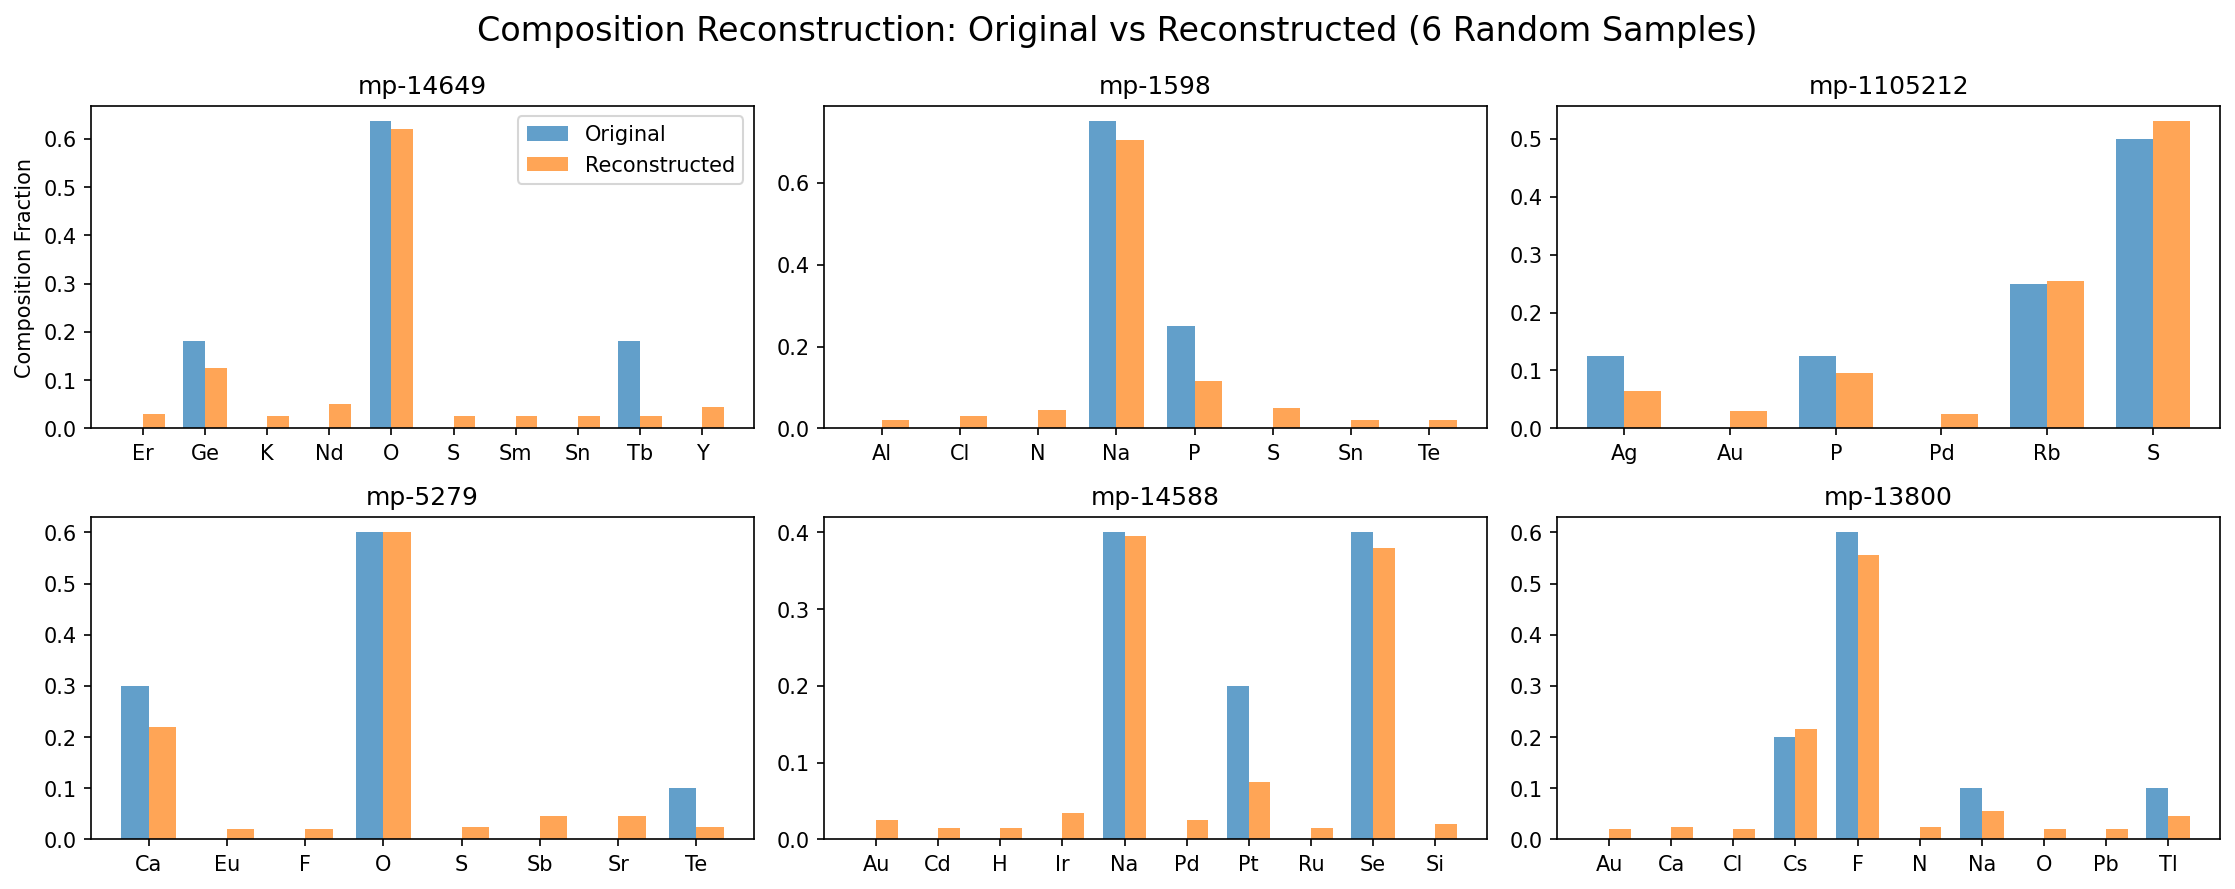


Average Element Set Jaccard Similarity: 0.3954


In [6]:
from loguru import logger as fm_logger
from matplotlib.ticker import MaxNLocator
fm_logger.disable("foundation_model")

target_name = 'Dielectric total (normalized)'
# target_name = 'Dielectric ionic (normalized)'
# target_name = 'Dielectric electronic (normalized)'

descriptor_path = Path('../data/qc_ac_te_mp_dos_kmd1d_desc_20250615.pd.parquet')
target_path = Path('../data/qc_ac_te_mp_dos_reformat_20250615.pd.parquet')

properties = pd.read_parquet(target_path)[[target_name, target_name[:-13], "composition"]]
properties.composition = properties.composition.apply(lambda x: {k: v for k, v in x.items() if v is not None})
properties = properties[properties[target_name[:-13]] < 1000]
descriptors = pd.read_parquet(descriptor_path).loc[properties.index]

# Merge and keep numeric descriptor columns
merged = descriptors.join(properties).dropna(subset=[target_name])
descriptor_cols = [c for c in descriptors.columns if pd.api.types.is_numeric_dtype(descriptors[c])]
X_full = torch.tensor(merged[descriptor_cols].values, dtype=torch.float32)
y_full = torch.tensor(merged[target_name].values, dtype=torch.float32).unsqueeze(1)

max_samples = 50000
if len(X_full) > max_samples:
    X_full = X_full[:max_samples]
    y_full = y_full[:max_samples]

# Split into train (80%), val (10%), test (10%)
n_samples = len(X_full)
indices = torch.randperm(n_samples)
n_train = int(0.8 * n_samples)
n_val = int(0.1 * n_samples)

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train+n_val]
test_idx = indices[n_train+n_val:]

X = X_full[train_idx].to(device)
y = y_full[train_idx].to(device)
X_val = X_full[val_idx].to(device)
y_val = y_full[val_idx].to(device)
X_test = X_full[test_idx].to(device)
y_test = y_full[test_idx].to(device)

input_dim = X.shape[1]
latent_dim = 128

encoder_config = MLPEncoderConfig(hidden_dims=[input_dim, 256, latent_dim], norm=True)
density_task = RegressionTaskConfig(
    name=target_name,
    data_column=target_name,
    dims=[latent_dim, 64, 32, 1],
    norm=True,
)
ae_task = AutoEncoderTaskConfig(
    name='reconstruction',
    data_column='__autoencoder__',
    dims=[latent_dim, 256, input_dim],
    norm=True,
)

model = FlexibleMultiTaskModel(
    encoder_config=encoder_config,
    task_configs=[density_task, ae_task],
    shared_block_optimizer=OptimizerConfig(lr=5e-3),
).to(device)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=256, shuffle=True)
optim = torch.optim.Adam(model.parameters(), lr=5e-3)

model.train()
for epoch in range(500):
    total = 0.0
    for batch_x, batch_y in loader:
        optim.zero_grad()
        # UPDATED: Use model's forward() which applies Tanh uniformly
        outputs = model(batch_x)
        pred = outputs[target_name]
        recon = outputs['reconstruction']
        loss = F.mse_loss(pred, batch_y) + F.mse_loss(recon, batch_x)
        loss.backward()
        optim.step()
        total += loss.item() * batch_x.size(0)
    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch+1}: loss={total / len(dataset):.4f}')

model.eval()
print(f'Training complete. Samples used: {len(dataset)}, input_dim={input_dim}')


# Scatter plot showing model predictions vs actual targets on training and test data
with torch.no_grad():
    train_preds = model(X)[target_name].cpu().numpy()
    test_preds = model(X_test)[target_name].cpu().numpy()

train_targets = y.cpu().numpy()
test_targets = y_test.cpu().numpy()
# Calculate metrics for the test set
test_mae = np.mean(np.abs(test_preds - test_targets))
test_rmse = np.sqrt(np.mean((test_preds - test_targets) ** 2))
test_r2 = 1 - np.sum((test_preds - test_targets) ** 2) / np.sum((test_targets - np.mean(test_targets)) ** 2)

# Prepare text string
metrics_text = f"Test Metrics:\nMAE: {test_mae:.4f}\nRMSE: {test_rmse:.4f}\nR²: {test_r2:.4f}"

# Monkey-patch plt.show to inject the text box before showing the plot
_original_show = plt.show
def _show_with_metrics(*args, **kwargs):
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    _original_show(*args, **kwargs)
    plt.show = _original_show  # Restore original function

plt.show = _show_with_metrics
plt.figure(figsize=(8, 8))
plt.scatter(train_targets, train_preds, alpha=0.3, s=20, label='Train', color='blue')
plt.scatter(test_targets, test_preds, alpha=0.5, s=20, label='Test', color='orange', edgecolors='k', linewidth=0.5)

all_targets = np.concatenate([train_targets, test_targets])
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--', linewidth=2, label='Perfect prediction')
plt.xlabel(f'Observed {target_name}')
plt.ylabel(f'Predicted {target_name}')
plt.title(f'Model Results (Train n={len(train_targets)}, Test n={len(test_targets)})')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print evaluation metrics
for name, preds, targets in [('Train', train_preds, train_targets), ('Test', test_preds, test_targets)]:
    mae = np.abs(preds - targets).mean()
    rmse = np.sqrt(((preds - targets) ** 2).mean())
    r2 = 1 - ((preds - targets) ** 2).sum() / ((targets - targets.mean()) ** 2).sum()
    print(f'\n{name} Set Metrics:')
    print(f'  MAE:  {mae:.4f}')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  R²:   {r2:.4f}')

# Evaluate AutoEncoder reconstruction performance
with torch.no_grad():
    # Get reconstructions for the test set
    test_outputs = model(X_test)
    test_recon = test_outputs['reconstruction']

    # Calculate reconstruction metrics (MSE and MAE)
    recon_mse = F.mse_loss(test_recon, X_test).item()
    recon_mae = torch.abs(test_recon - X_test).mean().item()

print("\nAutoEncoder Reconstruction Metrics (Test Set):")
print(f"  MSE: {recon_mse:.6f}")
print(f"  MAE: {recon_mae:.6f}")

# Optional: Visualize reconstruction for a few features of the first sample
import matplotlib.pyplot as plt
# Monkey-patch plt.show to ensure integer ticks on x-axis
_original_show_recon = plt.show
def _show_with_int_ticks(*args, **kwargs):
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    _original_show_recon(*args, **kwargs)
    plt.show = _original_show_recon  # Restore original function

plt.show = _show_with_int_ticks
n_features_to_plot = min(20, input_dim)
plt.figure(figsize=(15, 6), dpi=150)
plt.bar(range(n_features_to_plot), X_test[0, :n_features_to_plot].cpu().numpy(), alpha=0.6, label='Original')
plt.bar(range(n_features_to_plot), test_recon[0, :n_features_to_plot].cpu().numpy(), alpha=0.6, label='Reconstructed', width=0.5)
plt.legend()
plt.title(f'Reconstruction of First {n_features_to_plot} Features (Test Sample 0)')
plt.xlabel('Descriptor Index')
plt.ylabel('Value')
plt.show()

test_recon_np = test_recon.cpu().numpy()
joblib.dump(test_recon_np, '../data/test_reconstruct.pkl.z')

# --- NEW SECTION: Composition Reconstruction Analysis ---
print("\nAnalyzing Composition Reconstruction...")

# 1. Inverse transform descriptors to weights
# Note: kmd_1d and component_features are expected to be in the global scope from previous cells
decoded_weights = kmd_1d.inverse_transform(test_recon_np)

# 2. Convert weights to compositions
reconstructed_compositions = decoded_weight_to_composition(
    decoded_weights,
    component_features,
    min_ratio=0.01 # Using a small threshold to filter noise
)

# 3. Get original compositions for the test set
# We need to map back from test_idx to the original properties DataFrame
test_indices_list = test_idx.cpu().numpy()
original_compositions = properties.iloc[test_indices_list]['composition'].tolist()
original_ids = properties.iloc[test_indices_list].index.tolist() # Get original IDs

# Helper function to normalize composition to percentages
def normalize_composition(comp_dict):
    total = sum(comp_dict.values())
    if total == 0: return comp_dict
    return {k: round(v / total, 3) for k, v in comp_dict.items()}

# 4. Store comparisons and visualize random samples
comparison_results = []
for i in range(len(reconstructed_compositions)):
    orig_norm = normalize_composition(original_compositions[i])
    recon = reconstructed_compositions[i]
    comparison_results.append({
        'original': orig_norm,
        'reconstructed': recon,
        'index': i,
        'id': original_ids[i] # Store original ID
    })

# Randomly select 6 samples for visualization
# random.seed(42) # For reproducibility
sample_indices = random.sample(range(len(comparison_results)), 6)

# Create 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 6), dpi=150)
fig.suptitle('Composition Reconstruction: Original vs Reconstructed (6 Random Samples)', fontsize=16)
axes = axes.flatten() # Flatten to iterate easily

for idx, sample_idx in enumerate(sample_indices):
    sample = comparison_results[sample_idx]
    orig = sample['original']
    recon = sample['reconstructed']
    sample_id = sample['id']

    # Get union of elements
    all_elements = sorted(list(set(orig.keys()) | set(recon.keys())))

    orig_vals = [orig.get(e, 0.0) for e in all_elements]
    recon_vals = [recon.get(e, 0.0) for e in all_elements]

    x = np.arange(len(all_elements))
    width = 0.35

    ax = axes[idx]
    ax.bar(x - width/2, orig_vals, width, label='Original', alpha=0.7)
    ax.bar(x + width/2, recon_vals, width, label='Reconstructed', alpha=0.7)

    ax.set_xticks(x)
    ax.set_xticklabels(all_elements, rotation=0)
    ax.set_title(f'{sample_id}') # Use original ID in title
    if idx == 0:
        ax.set_ylabel('Composition Fraction')
        ax.legend()

plt.tight_layout()
plt.show()

# Optional: Calculate a simple similarity metric (e.g., Jaccard index of elements)
def get_elements(comp_dict):
    return set(comp_dict.keys())

jaccard_scores = []
for orig, recon in zip(original_compositions, reconstructed_compositions):
    elems_orig = get_elements(orig)
    elems_recon = get_elements(recon)
    intersection = len(elems_orig.intersection(elems_recon))
    union = len(elems_orig.union(elems_recon))
    jaccard_scores.append(intersection / union if union > 0 else 0.0)

print(f"\nAverage Element Set Jaccard Similarity: {np.mean(jaccard_scores):.4f}")

## Strategy 1: Random Initialization (data-driven seed)

We start from a random seed in input space (same dimensionality as the descriptors).

In [7]:
merged[merged[target_name] > 2.6]["Dielectric total (normalized)"].max()

np.float64(2.6925720077466373)

Selected Seed ID: mp-21276
Original Dielectric total (normalized): 2.6926

Running optimization with 6 restarts (perturbation)...


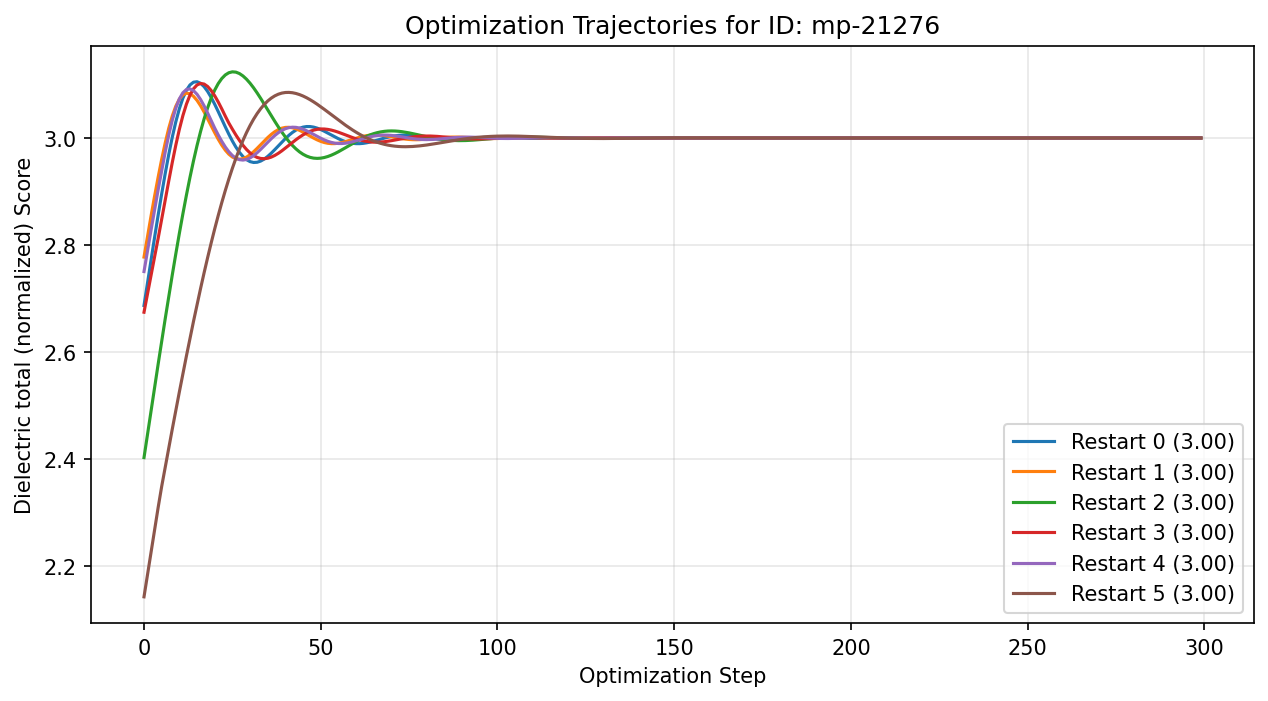


Analyzing Composition Reconstruction for each restart...


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


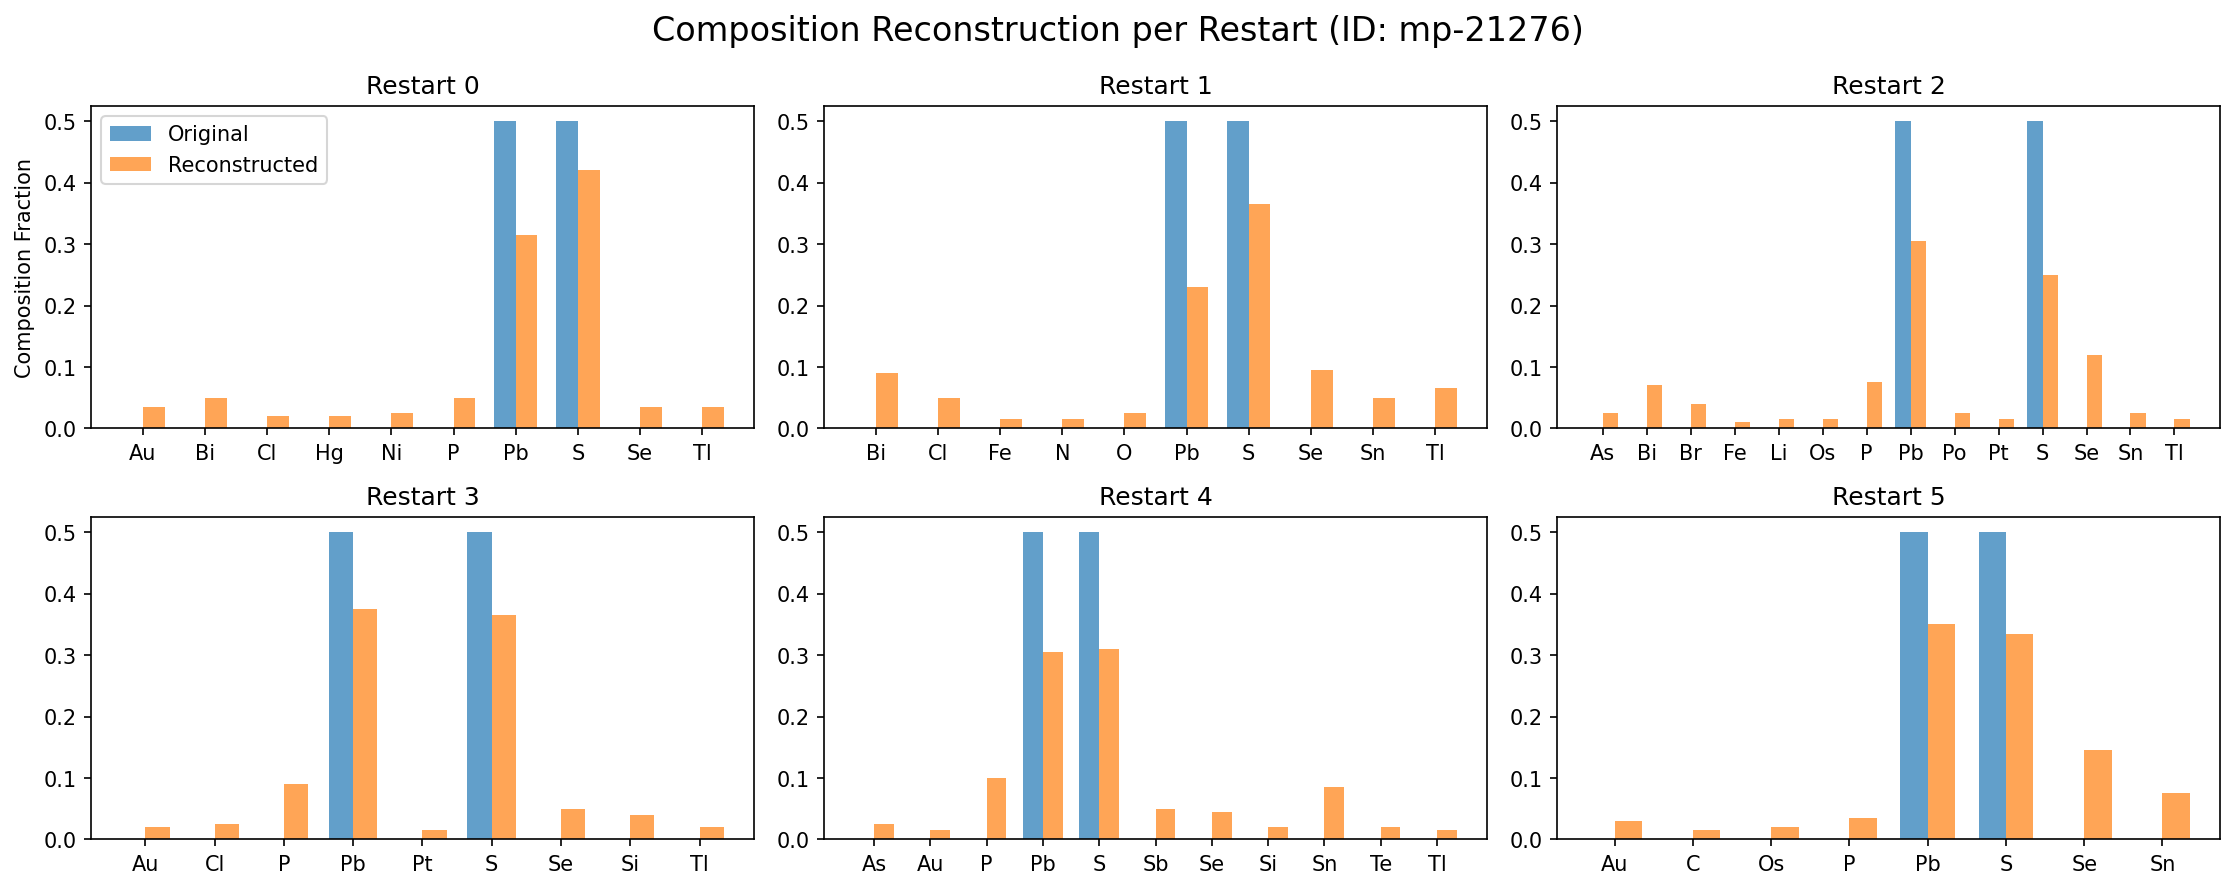


Prediction Consistency Check:
Original ID: mp-21276
Original Value (Raw):  323.7563
----------------------------------------------------------------------------------------------------
Restart  | Orig(Norm)   | Init Pred    | Target Score | Recon Pred   | Consist Diff
----------------------------------------------------------------------------------------------------
0        | 2.6926       | 2.3916       | 3.0000       | 2.7929       | -0.2071     
1        | 2.6926       | 2.3916       | 3.0000       | 2.7252       | -0.2748     
2        | 2.6926       | 2.3916       | 3.0000       | 2.4939       | -0.5061     
3        | 2.6926       | 2.3916       | 3.0000       | 2.5944       | -0.4056     
4        | 2.6926       | 2.3916       | 3.0000       | 2.4493       | -0.5507     
5        | 2.6926       | 2.3916       | 3.0000       | 2.6033       | -0.3967     

Prediction consistency results saved to '../data/prediction_consistency.csv'
Definitions:
  Target Score:     The score achi

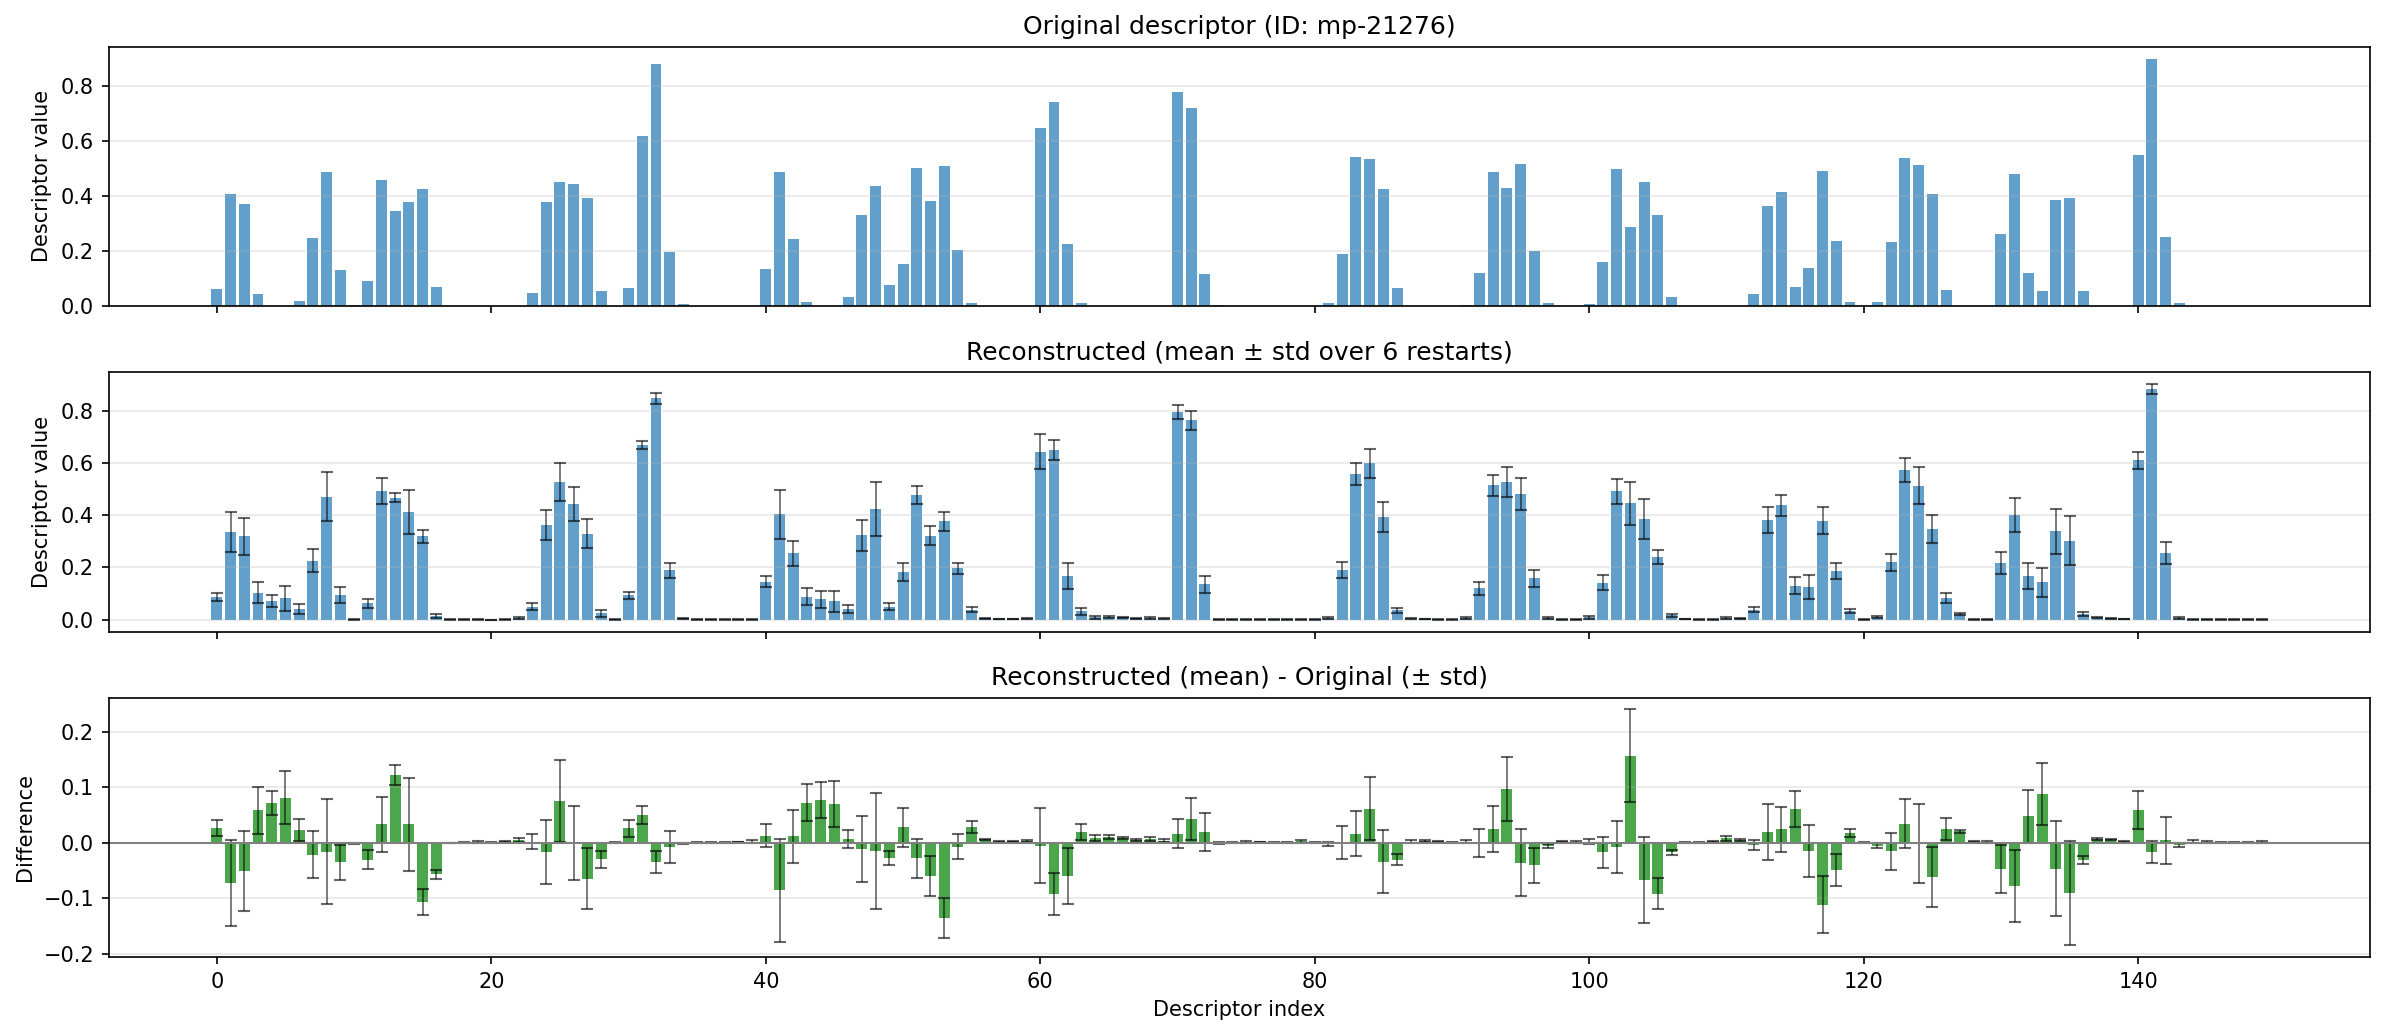

Descriptor statistics (first 100 features):
Original:
  Mean: 0.1746
  Std: 0.2248
  Range: [0.0000, 0.9006]
Multi-Restart (mean):
  Mean: 0.1740
  Std: 0.2190
  Range: [0.0004, 0.8833]


['../data/advanced_optimization_result.pkl.z']

In [28]:
# Merged Strategy: Single Seed Perturbation Analysis
import random
import joblib

# 1. Select a single random seed from the high-value candidates
# Redefine seed_batch_pd as it was in the original Cell 13
seed_batch_pd = merged[merged[target_name] > 2.6].iloc[:, :-3]

random_idx = random.randint(0, len(seed_batch_pd) - 1)
single_seed_pd = seed_batch_pd.iloc[random_idx]
single_seed_tensor = torch.tensor(single_seed_pd.values, dtype=torch.float32).to(device).unsqueeze(0)
original_id = single_seed_pd.name

print(f"Selected Seed ID: {original_id}")
print(f"Original {target_name}: {merged.loc[original_id, target_name]:.4f}")

# 2. Run optimization with perturbation (6 restarts)
num_restarts = 6
print(f"\nRunning optimization with {num_restarts} restarts (perturbation)...")

# We use the same initial input for all restarts, but the model's optimize_latent
# handles perturbation internally if num_restarts > 1 and perturbation_std > 0
result_perturb = model.optimize_latent(
    task_name=target_name,
    initial_input=single_seed_tensor,
    # mode="max",
    target_value=3.0,
    steps=300,
    lr=0.005,
    num_restarts=num_restarts,
    perturbation_std=0.3,
    optimize_space="latent",
    ae_task_name="reconstruction",
)

# 3. Visualize Optimization Process
traj = result_perturb.trajectory[0, :, :, 0].detach().cpu().numpy() # (num_restarts, steps)
plt.figure(figsize=(10, 5), dpi=150)
for i in range(num_restarts):
    final_score = result_perturb.optimized_target[0, i, 0].item()
    plt.plot(traj[i], label=f'Restart {i} ({final_score:.2f})')
plt.xlabel('Optimization Step')
plt.ylabel(f'{target_name} Score')
plt.title(f'Optimization Trajectories for ID: {original_id}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 4. Analyze Composition Reconstruction
print("\nAnalyzing Composition Reconstruction for each restart...")

# Get optimized inputs (reconstructed descriptors)
optimized_inputs = result_perturb.optimized_input[0].detach().cpu().numpy() # (num_restarts, input_dim)

# Inverse transform to compositions
decoded_weights = kmd_1d.inverse_transform(optimized_inputs)
reconstructed_compositions = decoded_weight_to_composition(
    decoded_weights,
    component_features,
    min_ratio=0.01
)

# Get original composition
original_comp_dict = properties.loc[original_id, 'composition']
original_comp_norm = normalize_composition(original_comp_dict)

# Plot 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 6), dpi=150)
fig.suptitle(f'Composition Reconstruction per Restart (ID: {original_id})', fontsize=16)
axes = axes.flatten()

for i in range(num_restarts):
    recon = reconstructed_compositions[i]

    # Union of elements
    all_elements = sorted(list(set(original_comp_norm.keys()) | set(recon.keys())))

    orig_vals = [original_comp_norm.get(e, 0.0) for e in all_elements]
    recon_vals = [recon.get(e, 0.0) for e in all_elements]

    x = np.arange(len(all_elements))
    width = 0.35

    ax = axes[i]
    ax.bar(x - width/2, orig_vals, width, label='Original', alpha=0.7)
    ax.bar(x + width/2, recon_vals, width, label='Reconstructed', alpha=0.7)

    ax.set_xticks(x)
    ax.set_xticklabels(all_elements, rotation=0)
    ax.set_title(f'Restart {i}')
    if i == 0:
        ax.set_ylabel('Composition Fraction')
        ax.legend()

plt.tight_layout()
plt.show()

# 5. Compare Predictions: Optimized Score vs Actual Prediction on Reconstructed
print("\nPrediction Consistency Check:")

# Get original values and initial prediction
original_val_norm = merged.loc[original_id, target_name]
original_val_raw = merged.loc[original_id, target_name[:-13]]

with torch.no_grad():
    initial_pred = model(single_seed_tensor)[target_name].item()

print(f"Original ID: {original_id}")
print(f"Original Value (Raw):  {original_val_raw:.4f}")

print("-" * 100)
print(f"{'Restart':<8} | {'Orig(Norm)':<12} | {'Init Pred':<12} | {'Target Score':<12} | {'Recon Pred':<12} | {'Consist Diff':<12}")
print("-" * 100)

# Predict using the model on the reconstructed inputs
with torch.no_grad():
    # optimized_inputs is numpy, convert to tensor
    inputs_tensor = torch.tensor(optimized_inputs, dtype=torch.float32).to(device)
    predictions = model(inputs_tensor)[target_name].cpu().numpy().flatten()

optimized_scores = result_perturb.optimized_target[0, :, 0].detach().cpu().numpy()

consistency_data = []
for i in range(num_restarts):
    target_score = optimized_scores[i]
    pred_score = predictions[i]

    # Consistency Diff: Difference between model prediction on reconstructed input and the optimization target
    # (Recon Pred - Target Score)
    consist_diff = pred_score - target_score

    print(f"{i:<8} | {original_val_norm:<12.4f} | {initial_pred:<12.4f} | {target_score:<12.4f} | {pred_score:<12.4f} | {consist_diff:<12.4f}")

    consistency_data.append({
        'Restart': i,
        'Original ID': original_id,
        'Original Value (Raw)': original_val_raw,
        'Original Value (Norm)': original_val_norm,
        'Initial Prediction': initial_pred,
        'Target Score': target_score,
        'Recon Prediction': pred_score,
        'Consistency Diff': consist_diff
    })

# Save consistency results
consistency_df = pd.DataFrame(consistency_data)
consistency_df.to_csv('../data/prediction_consistency.csv', index=False)
print("\nPrediction consistency results saved to '../data/prediction_consistency.csv'")
print("Definitions:")
print("  Target Score:     The score achieved by the latent optimization process.")
print("  Recon Prediction: The model's prediction on the reconstructed descriptors.")
print("  Consistency Diff: (Recon Prediction - Target Score). Measures if the reconstructed input preserves the optimized property.")

# 6. Analyze Reconstructed Descriptors
print("\nAnalyzing Reconstructed Descriptors...")

descriptors_ = {
    'Original': single_seed_pd.values.flatten(),
    'Multi-Restart (mean)': optimized_inputs.mean(axis=0),
}

# Visualize first n_show features with error bars
n_show = 150
fig, axes = plt.subplots(3, 1, figsize=(16, 7), sharex=True, dpi=150)

# Original plot
axes[0].bar(range(n_show), descriptors_['Original'][:n_show], alpha=0.7)
axes[0].set_ylabel('Descriptor value')
axes[0].set_title(f'Original descriptor (ID: {original_id})')
axes[0].grid(alpha=0.3, axis='y')

# Multi-restart mean with std as error bars
mean_vals = optimized_inputs.mean(axis=0)[:n_show]
std_vals = optimized_inputs.std(axis=0)[:n_show]
axes[1].bar(range(n_show), mean_vals, yerr=std_vals, alpha=0.7, capsize=3, error_kw={'linewidth': 0.8, 'alpha': 0.6})
axes[1].set_ylabel('Descriptor value')
axes[1].set_title(f'Reconstructed (mean ± std over {num_restarts} restarts)')
axes[1].grid(alpha=0.3, axis='y')

# Difference: Multi-Restart (mean) - Original with error bars
diff_vals = mean_vals - descriptors_['Original'][:n_show]
axes[2].bar(range(n_show), diff_vals, yerr=std_vals, alpha=0.7, capsize=3, error_kw={'linewidth': 0.8, 'alpha': 0.6}, color='green')
axes[2].axhline(0, color='gray', linestyle='-', linewidth=1)
axes[2].set_xlabel('Descriptor index')
axes[2].set_ylabel('Difference')
axes[2].set_title('Reconstructed (mean) - Original (± std)')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistical comparison
print('Descriptor statistics (first 100 features):')
for name, desc in descriptors_.items():
    print(f"{name}:")
    print(f"  Mean: {np.mean(desc[:n_show]):.4f}")
    print(f"  Std: {np.std(desc[:n_show]):.4f}")
    print(f"  Range: [{np.min(desc[:n_show]):.4f}, {np.max(desc[:n_show]):.4f}]")

# Save results
joblib.dump(result_perturb, '../data/advanced_optimization_result.pkl.z')

Results will be saved to: ../data/sensitivity_analysis_results
Selected 10 IDs for analysis: ['mp-1210092', 'mp-861937', 'mp-27853', 'mp-27655', 'mp-28011', 'mp-540771', 'mp-1103722', 'mp-13654', 'mp-17833', 'mp-545522']

Processing ID 1/10: mp-1210092
Original Value: 2.3643
Initial Pred:   1.9845
Target Values: ['2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.40...
  Optimization complete for mp-1210092.


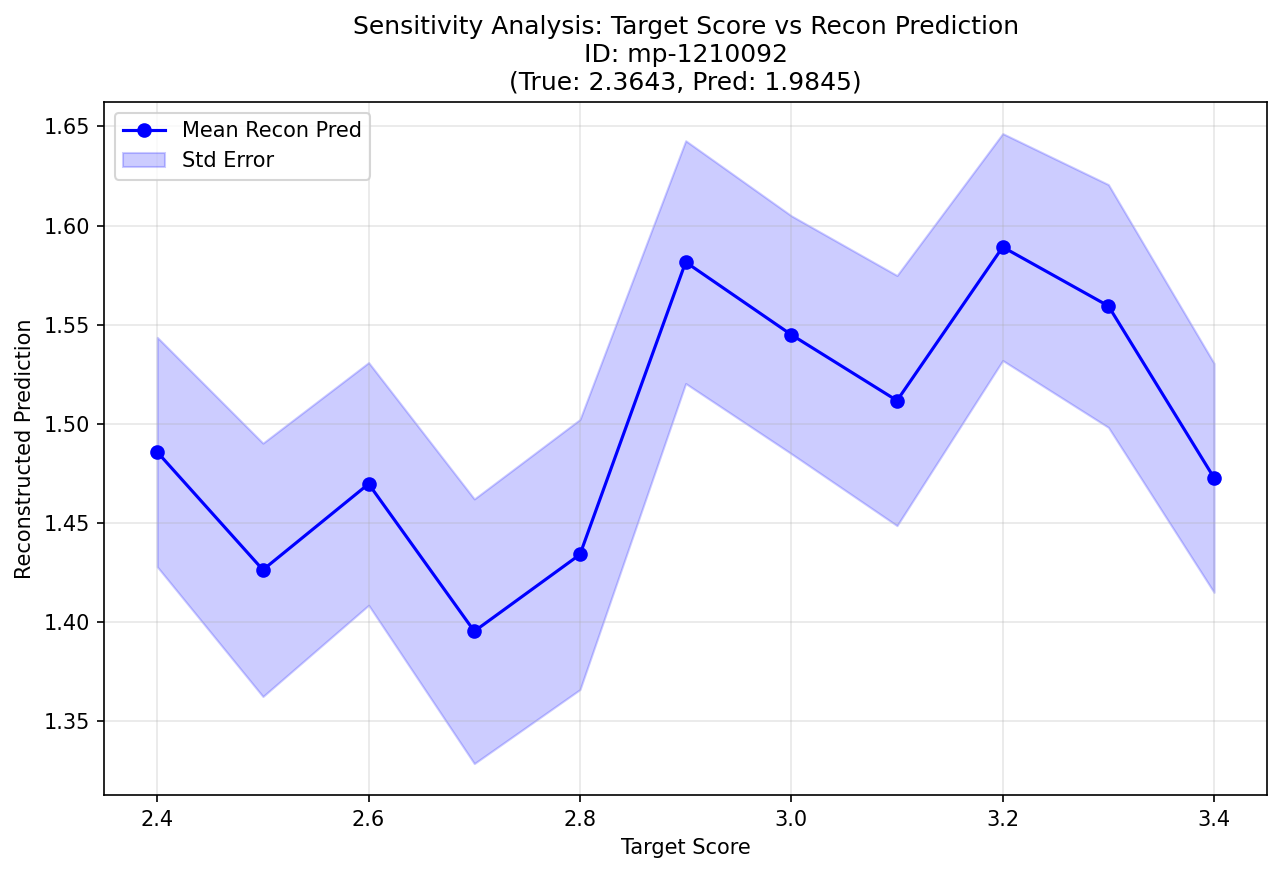


Processing ID 2/10: mp-861937
Original Value: 1.7842
Initial Pred:   1.8259
Target Values: ['1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.80...
  Optimization complete for mp-861937.


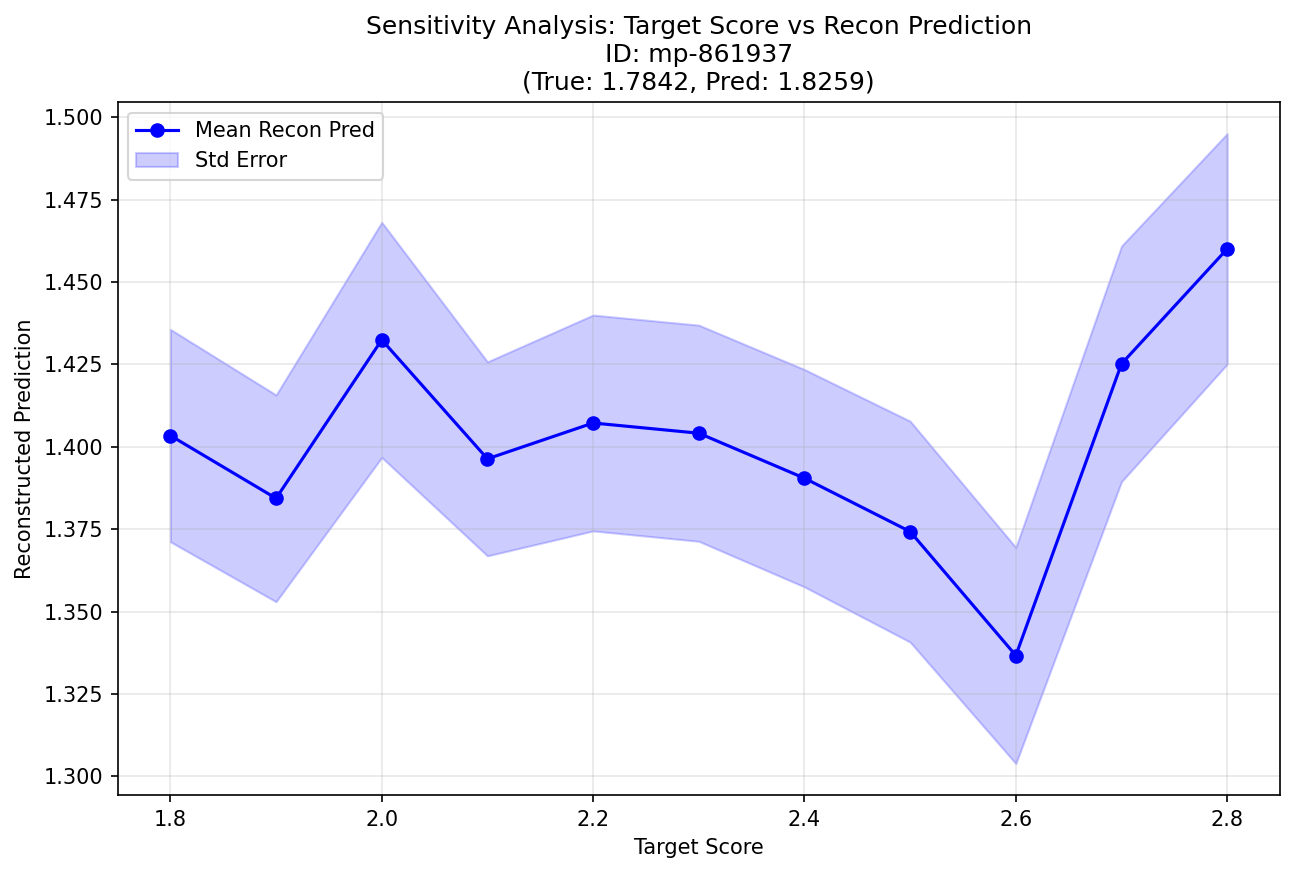


Processing ID 3/10: mp-27853
Original Value: 1.7601
Initial Pred:   1.7106
Target Values: ['1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.80...
  Optimization complete for mp-27853.


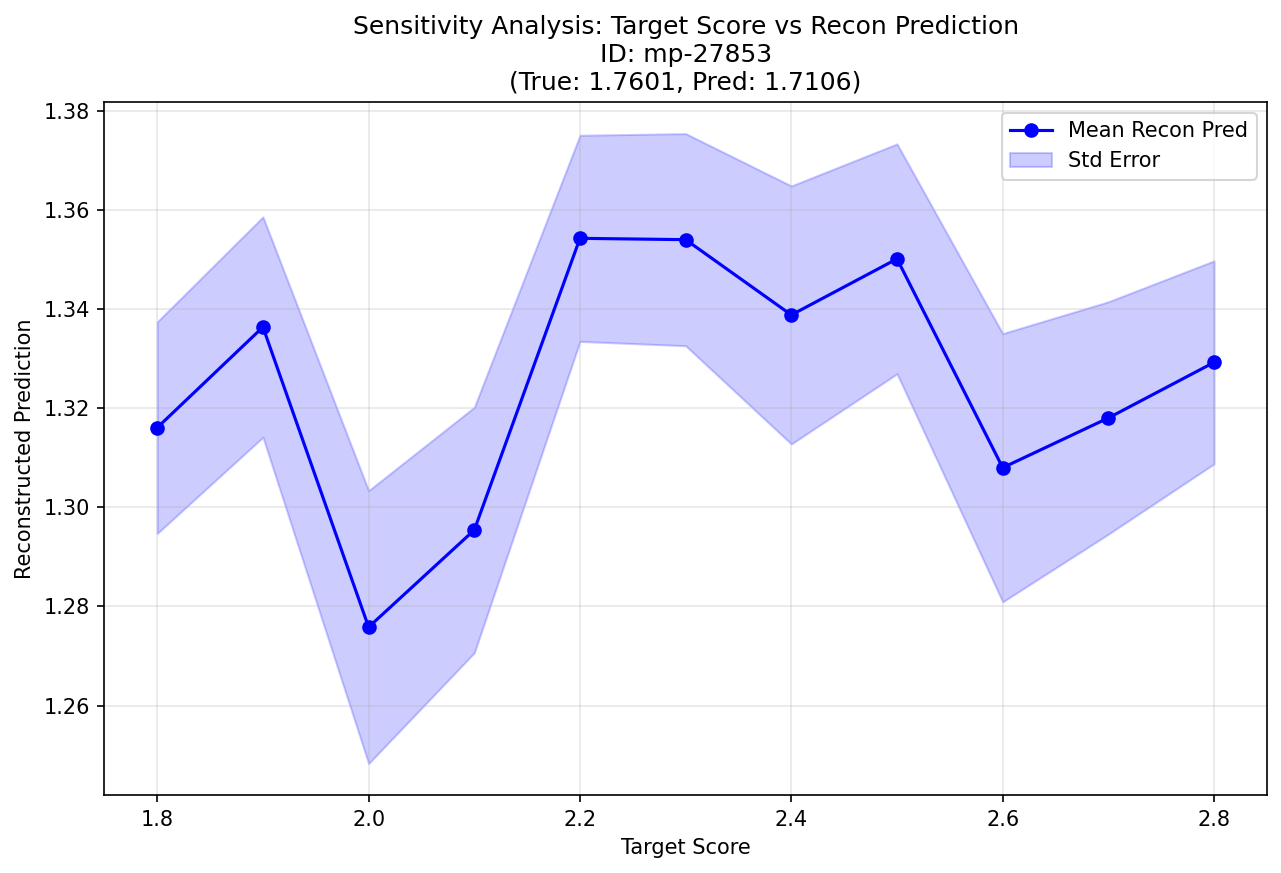


Processing ID 4/10: mp-27655
Original Value: 1.6213
Initial Pred:   1.6529
Target Values: ['1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.70...
  Optimization complete for mp-27655.


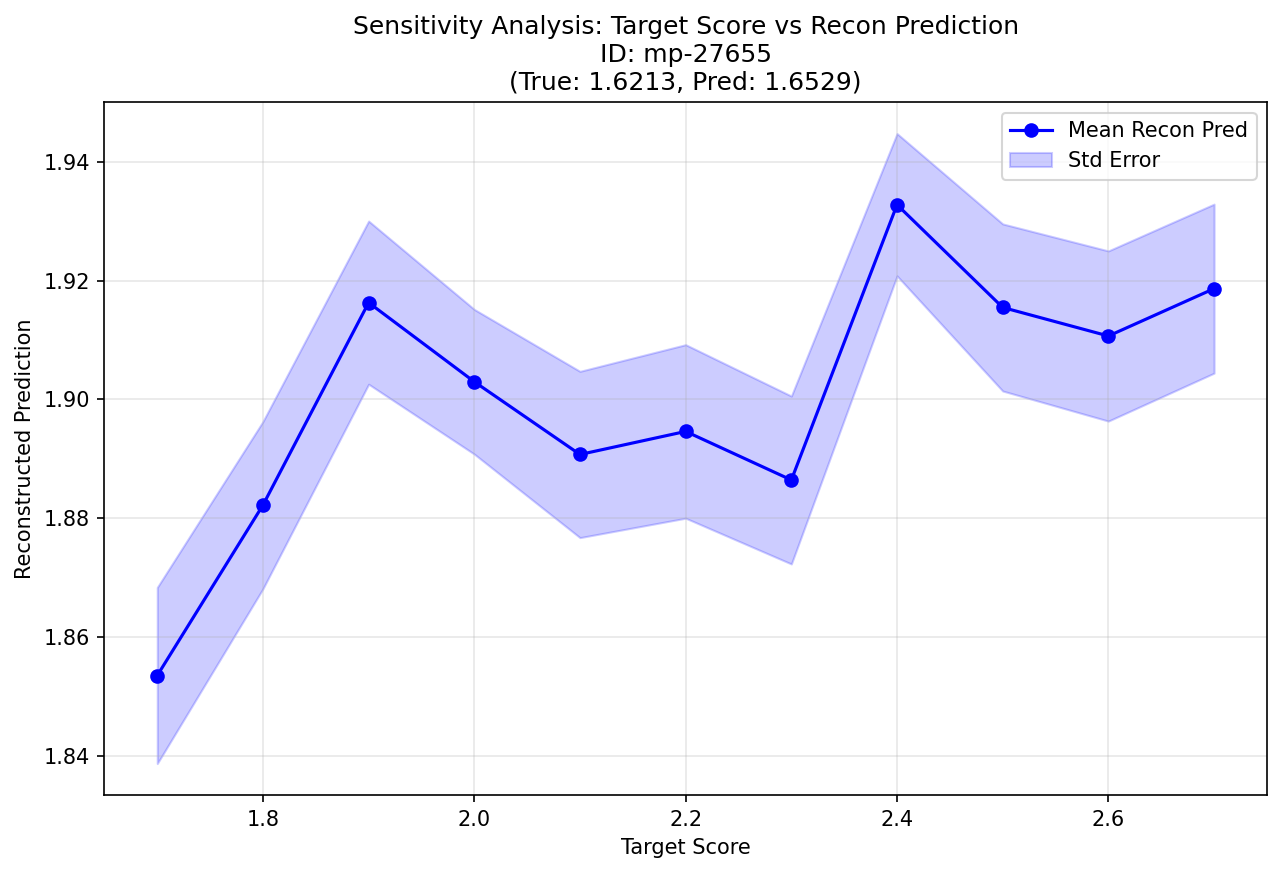


Processing ID 5/10: mp-28011
Original Value: 2.6845
Initial Pred:   2.6368
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-28011.


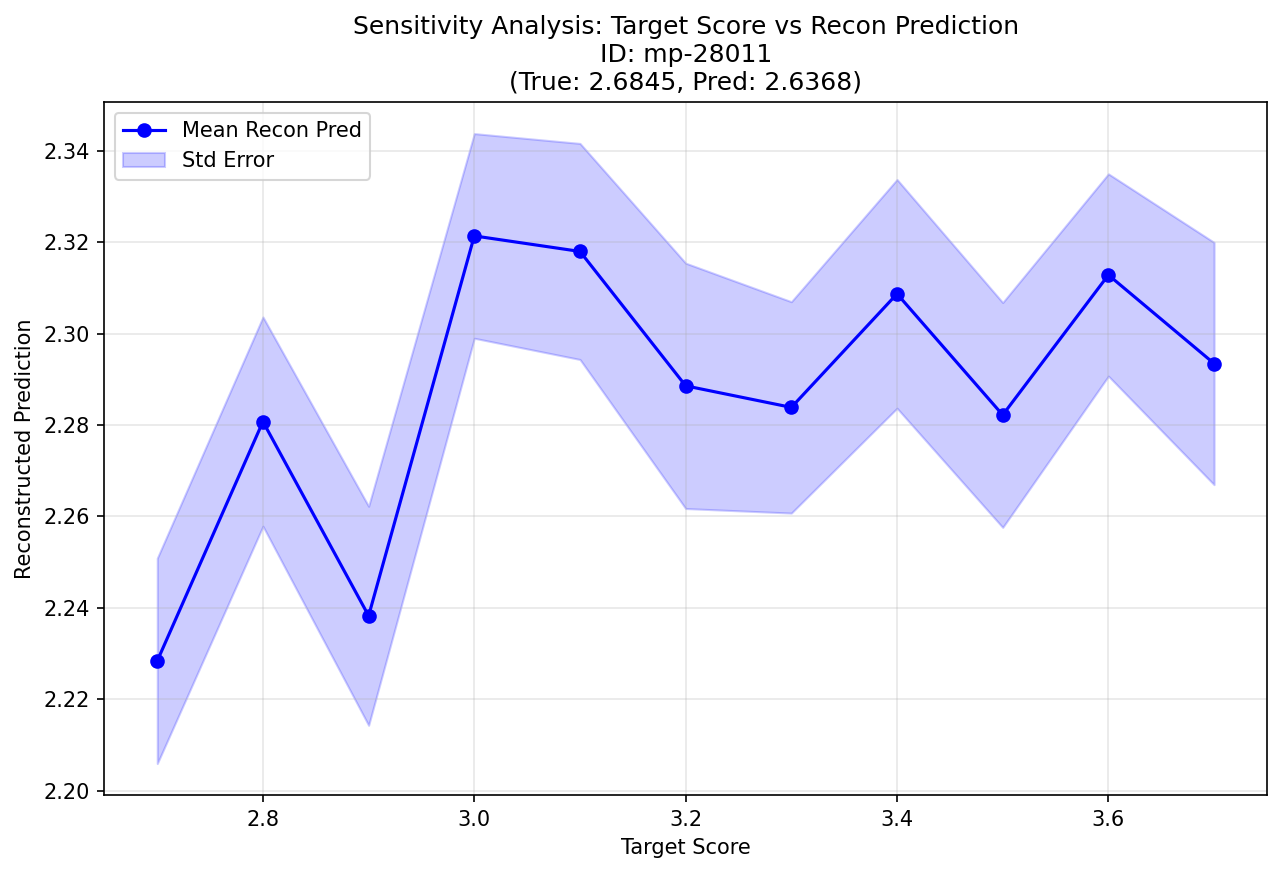


Processing ID 6/10: mp-540771
Original Value: 2.6489
Initial Pred:   2.4199
Target Values: ['2.70', '2.80', '2.90', '3.00', '3.10', '3.20', '3.30', '3.40', '3.50', '3.60', '3.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.70...
  Optimization complete for mp-540771.


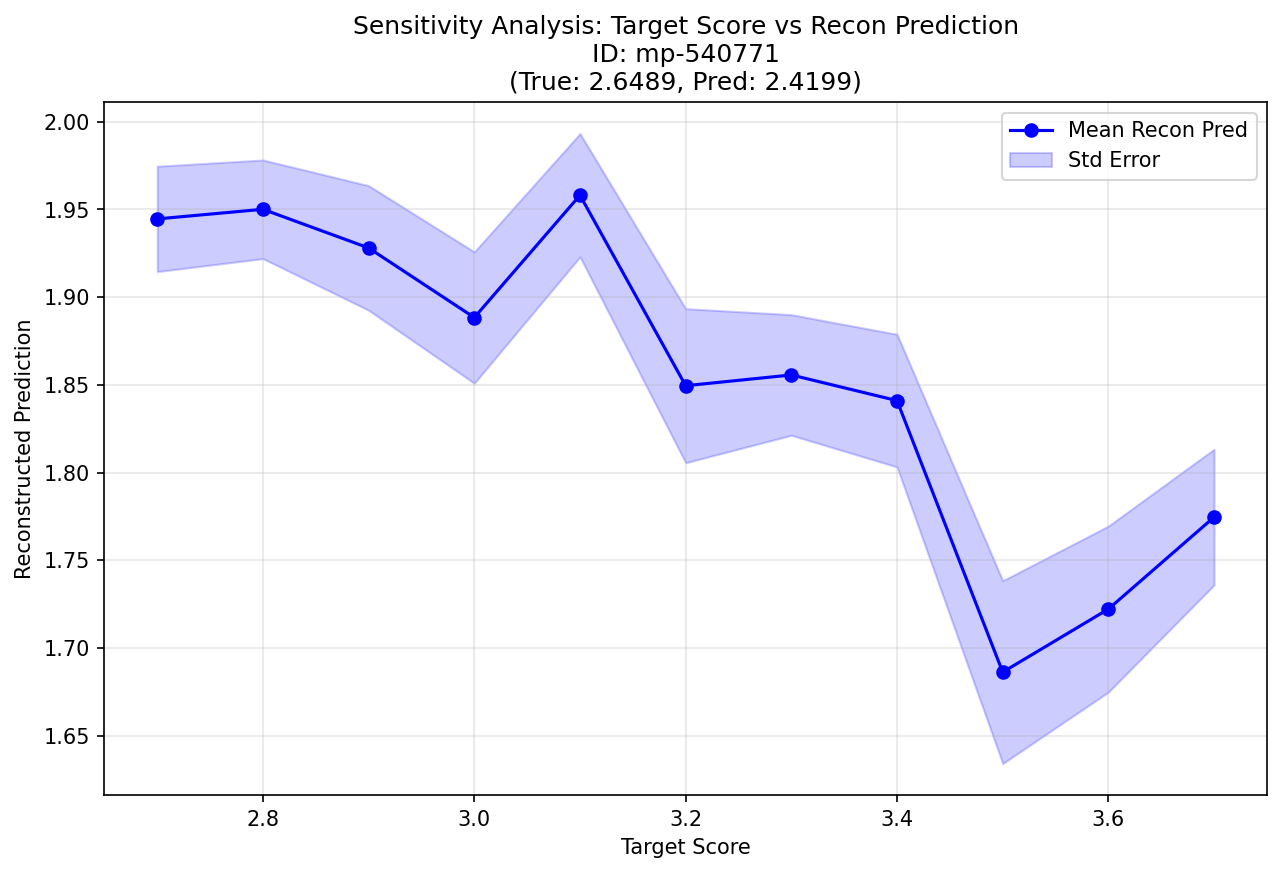


Processing ID 7/10: mp-1103722
Original Value: 1.9461
Initial Pred:   1.9927
Target Values: ['2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.00...
  Optimization complete for mp-1103722.


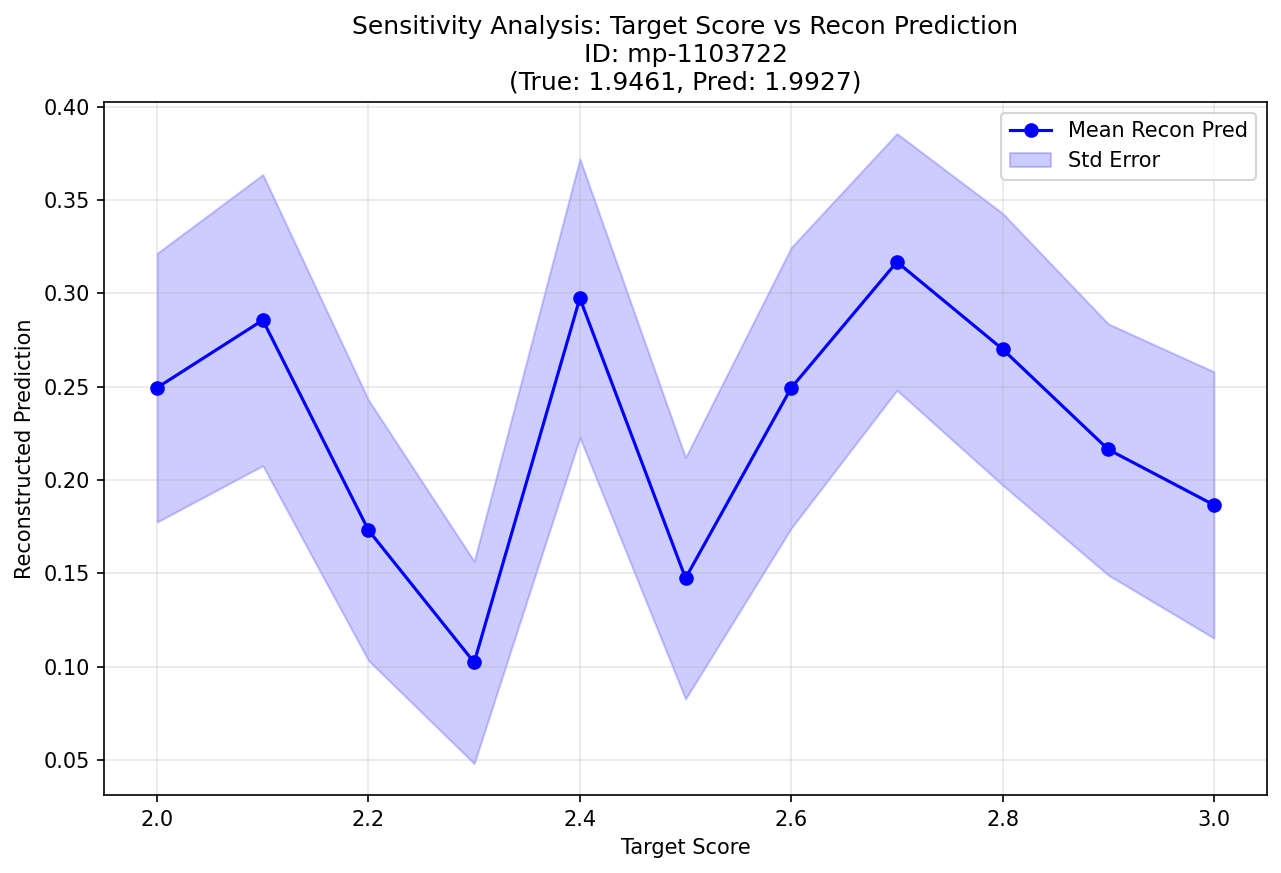


Processing ID 8/10: mp-13654
Original Value: 1.6654
Initial Pred:   1.4761
Target Values: ['1.70', '1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.70...
  Optimization complete for mp-13654.


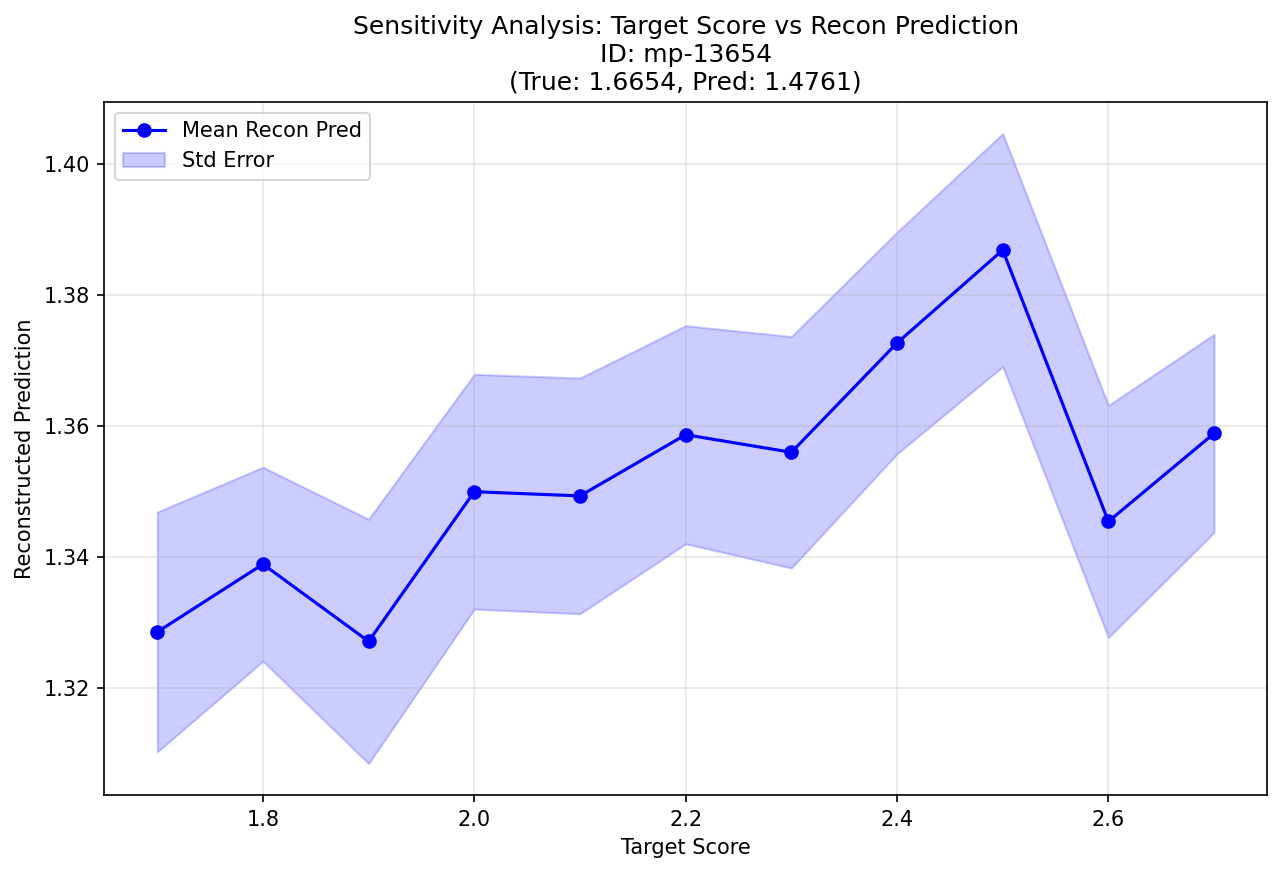


Processing ID 9/10: mp-17833
Original Value: 1.7811
Initial Pred:   1.8103
Target Values: ['1.80', '1.90', '2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 2.80...
  Optimization complete for mp-17833.


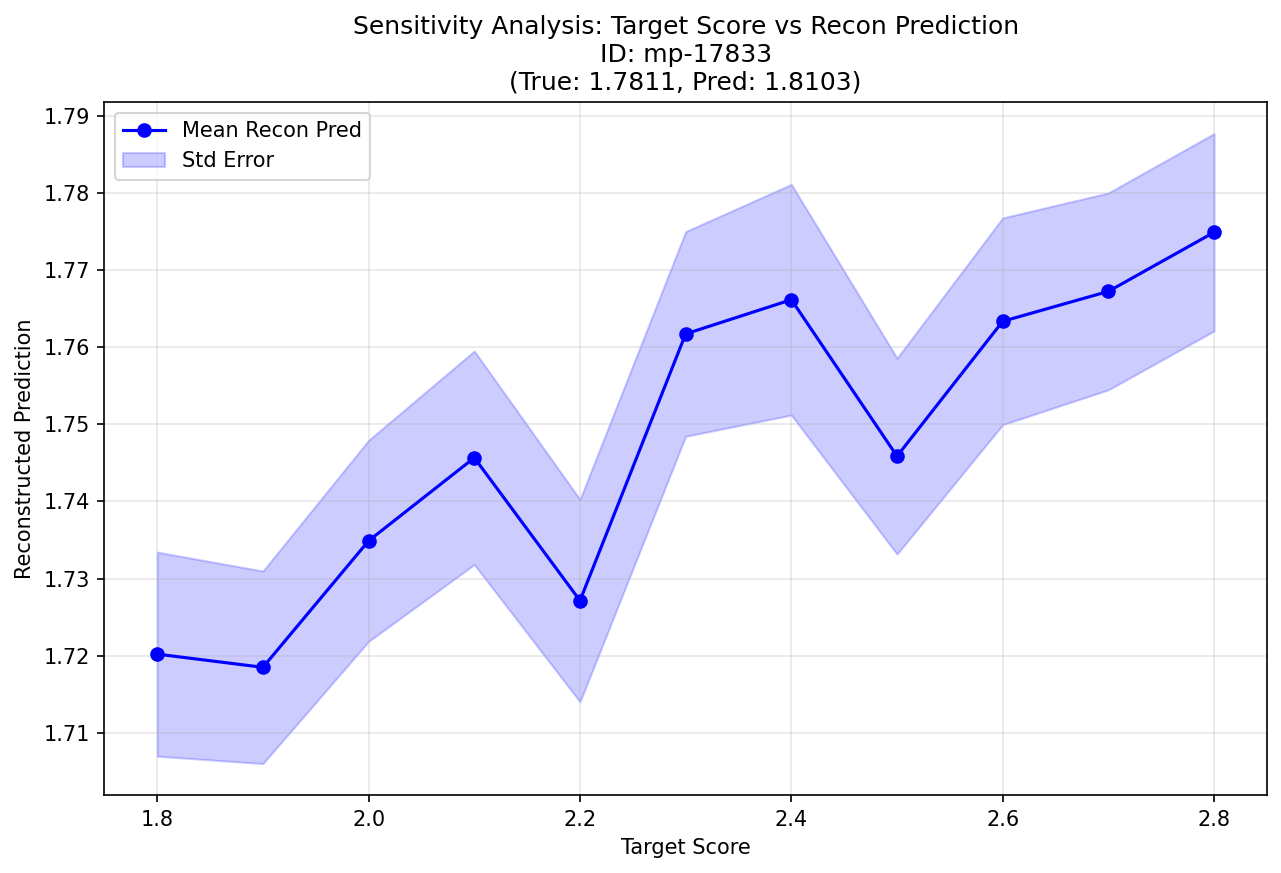


Processing ID 10/10: mp-545522
Original Value: 1.9182
Initial Pred:   1.6845
Target Values: ['2.00', '2.10', '2.20', '2.30', '2.40', '2.50', '2.60', '2.70', '2.80', '2.90', '3.00']


/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:287: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


  Optimizing for target: 3.00...
  Optimization complete for mp-545522.


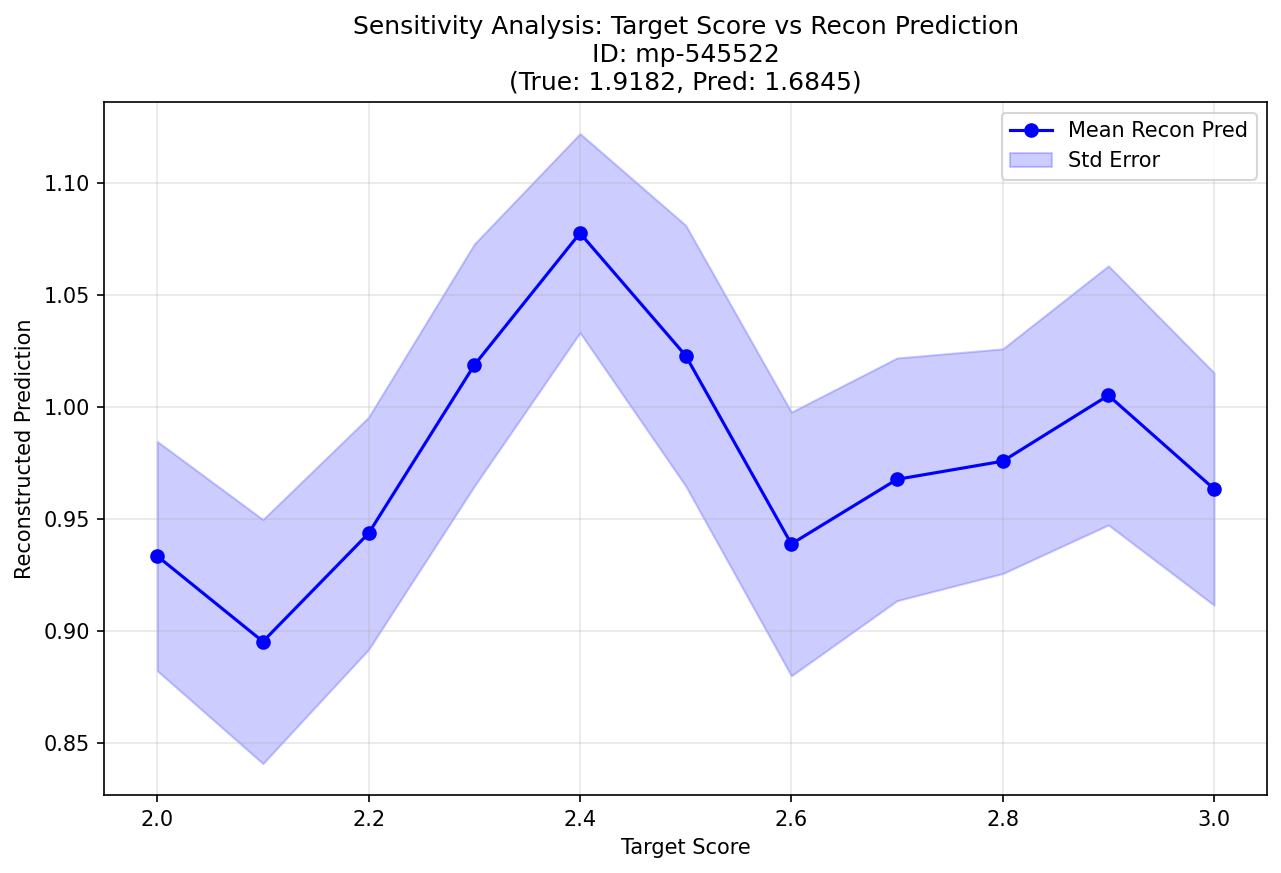


All 10 samples processed. Results saved to '../data/sensitivity_analysis_results'.


In [29]:
# Sensitivity Analysis: Target Score vs Recon Prediction (Batch of 10)
# Randomly select 10 samples with Target > 1.5 and run sensitivity analysis on each.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import os

# Create directory for results
output_dir = '../data/sensitivity_analysis_results'
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved to: {output_dir}")

# 1. Select 10 random IDs with target > 1.5
candidates = merged[merged[target_name] > 1.5]
if len(candidates) < 10:
    print(f"Warning: Only {len(candidates)} candidates found with {target_name} > 1.5. Using all.")
    selected_ids = candidates.index.tolist()
else:
    selected_ids = random.sample(candidates.index.tolist(), 10)

print(f"Selected 10 IDs for analysis: {selected_ids}")

# Ensure normalize_composition is available
def normalize_composition(comp_dict):
    total = sum(comp_dict.values())
    if total == 0: return comp_dict
    return {k: round(v / total, 3) for k, v in comp_dict.items()}

for idx, original_id in enumerate(selected_ids):
    print(f"\n{'='*50}")
    print(f"Processing ID {idx+1}/10: {original_id}")
    print(f"{'='*50}")

    # Prepare input tensor
    # Use descriptor_cols to extract only the features
    # Explicitly cast to float32 to avoid object dtype issues
    single_seed_values = merged.loc[original_id, descriptor_cols].values.astype(np.float32)
    single_seed_tensor = torch.tensor(single_seed_values, dtype=torch.float32).to(device).unsqueeze(0)

    # Get original values
    start_val = merged.loc[original_id, target_name]
    orig_comp = properties.loc[original_id, 'composition']
    orig_comp_norm = normalize_composition(orig_comp)

    # Get Initial Prediction
    with torch.no_grad():
        initial_pred = model(single_seed_tensor)[target_name].item()

    # Define target range
    # Start from the ceiling of the current value to the nearest 0.1
    start_target = np.ceil(start_val * 10) / 10
    # Generate 10 steps of 0.1 increase
    target_values = [start_target + i * 0.1 for i in range(11)]

    print(f"Original Value: {start_val:.4f}")
    print(f"Initial Pred:   {initial_pred:.4f}")
    # Simplified f-string to avoid potential syntax errors in some environments
    formatted_targets = [f'{t:.2f}' for t in target_values]
    print(f"Target Values: {formatted_targets}")

    results_sensitivity = []
    all_results_detailed = []

    for target in target_values:
        print(f"  Optimizing for target: {target:.2f}...", end='\r')

        # Run optimization with 50 restarts
        res = model.optimize_latent(
            task_name=target_name,
            initial_input=single_seed_tensor,
            mode="max",
            target_value=target,
            steps=300,   # Reduced steps for speed
            lr=0.005,     # Increased LR for speed
            num_restarts=100,
            perturbation_std=0.3,
            optimize_space="latent",
            ae_task_name="reconstruction",
        )

        # Get reconstructed predictions
        optimized_inputs = res.optimized_input[0].detach().cpu().numpy()
        inputs_tensor = torch.tensor(optimized_inputs, dtype=torch.float32).to(device)
        with torch.no_grad():
            preds = model(inputs_tensor)[target_name].cpu().numpy().flatten()

        # Decode Compositions
        decoded_weights = kmd_1d.inverse_transform(optimized_inputs)
        recon_comps = decoded_weight_to_composition(decoded_weights, component_features, min_ratio=0.05)

        # Store Detailed Results
        achieved_scores = res.optimized_target[0, :, 0].detach().cpu().numpy()

        for i in range(len(preds)):
            all_results_detailed.append({
                'Target Score': target,
                'Restart': i,
                'Original ID': original_id,
                'Original True Value': start_val,
                'Original Initial Prediction': initial_pred,
                'Original Composition': str(orig_comp),
                'Original Composition (Norm)': str(orig_comp_norm),
                'Reconstructed Composition': str(recon_comps[i]),
                'Reconstructed Prediction': preds[i],
                'Achieved Optimization Score': achieved_scores[i]
            })

        # Calculate stats
        mean_pred = np.mean(preds)
        std_pred = np.std(preds)
        stderr_pred = std_pred / np.sqrt(len(preds))

        results_sensitivity.append({
            'Target Score': target,
            'Recon Pred Mean': mean_pred,
            'Recon Pred Std': std_pred,
            'Recon Pred StdErr': stderr_pred
        })

    print(f"\n  Optimization complete for {original_id}.")

    # Save Results to output_dir (Modified Filenames)
    detailed_df = pd.DataFrame(all_results_detailed)
    detailed_df.to_csv(os.path.join(output_dir, f'{original_id}_sensitivity_detailed.csv'), index=False)

    sensitivity_df = pd.DataFrame(results_sensitivity)
    sensitivity_df.to_csv(os.path.join(output_dir, f'{original_id}_sensitivity_summary.csv'), index=False)

    # Plotting
    plt.figure(figsize=(10, 6), dpi=150)

    plt.plot(sensitivity_df['Target Score'], sensitivity_df['Recon Pred Mean'],
             marker='o', label='Mean Recon Pred', color='blue')

    plt.fill_between(
        sensitivity_df['Target Score'],
        sensitivity_df['Recon Pred Mean'] - sensitivity_df['Recon Pred StdErr'],
        sensitivity_df['Recon Pred Mean'] + sensitivity_df['Recon Pred StdErr'],
        color='blue', alpha=0.2, label='Std Error'
    )

    plt.xlabel('Target Score')
    plt.ylabel('Reconstructed Prediction')

    # Updated Title with Original Value and Initial Prediction
    title_str = f'Sensitivity Analysis: Target Score vs Recon Prediction\nID: {original_id}\n(True: {start_val:.4f}, Pred: {initial_pred:.4f})'
    plt.title(title_str)

    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(os.path.join(output_dir, f'{original_id}_sensitivity.png'))
    plt.show()

print(f"\nAll 10 samples processed. Results saved to '{output_dir}'.")